<a href="https://colab.research.google.com/github/fatima-bukhari5/liveness_detection_colab/blob/main/Liveness_VGG16_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Imports

In [15]:
# Reference section to call important lib.

# mathemathical & data manupulation
import numpy as np          # numpy for mathemathical operations
import pandas as pd         # to manage data in two dimension structures

# O/S, command line, serialization, deserialization, iterations
import argparse             # command line arguments management.
import pickle               # pickle for object serialization/de-serialization
import os                   # to interact with operating system
import itertools            # to enhance iteration over object, i.e. for loop

# image processing
import cv2                  # opencv for image pre-processing
from imutils import paths   # another convienance for image processing like opencv

# For Data visualization & charts
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Reference to Scikit Learn for data pre-processing & post training
# performance evaluation. 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Reference to keras with tensorflow engine for model training.
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.models import Model
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


### Importing Data Sets

In [16]:
INIT_LR = 0.0001  # a variable for learning rate parameter while training
BS = 10           # ??????
EPOCHS = 16        # a variable for number of epochs parameter while training model

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# location for training, validation & testing dataset 
train_path = '/content/drive/MyDrive/real_and_fake/train'
valid_path = '/content/drive/MyDrive/real_and_fake/valid'
test_path = '/content/drive/MyDrive/real_and_fake/test'

In [19]:
def read_image_data(X,Y):
    '''
    The following function is to convert the data into numpy array through
    `data_processing` function and resize it according vgg16 input size 
    of 224 by 224.
    
    Requirement:  Convert input images to 224x224 for VGG16
    Usage:        Pre-Processing.
    Functionality:
                  1. load images one by one from folder, resize & attach lable.
                  2. Convert image to numpy array & return array with lable. 
    Parameters:
                  X => df['Image paths'] (dataframe column of image paths)
                  Y => df['Labels'] (dataframe column of image labels)

    Returns:      `image` in the form of numpy array & labels as encoded.
    '''
    # to do: variables & parmeters naming convention.
    # declaration Section
    data =[]                                      # An array to hold images.
    labels = Y                                    # A variable to hold label from parameter.
    # execution section    
    # to do: exception handling
    for path in X:                                # for each image in a given folder.
        image = cv2.imread(path)                  # reading image from given path.
        image = cv2.resize(image,(224,224))       # resizing image as of input requirement.
        data.append(image)                        # add image to declared array structure.
    data, labels = data_processing(data, labels)  # Calling & passing parameters to data_processing function.
    # to do: use python log api for console message, if any. print is childish.
    print('[INFO] Converting Data into Image form and encoding labels')
    # return section
    return data, labels

In [20]:
def data_organization(img_path):
    '''
    This function is to organize the data in the form of data frames to have clear understanding 
    and readability of data w.r.t to its labels

    Parameters: 
    img_path = folder path of images base folder as string

    Returns: dataframe with organized image paths and their labels
    '''
    print("Getting labels for images...")
    data = []
    labels = []
    list_image_path = []
    folders_list = os.listdir(img_path)
    
    # loop over all folders at a time. i.e real and fake
    for folder in folders_list:
        
        # extract the class label from the filename to add into the df
    
        folder_path = os.path.join(img_path,folder)
        images_list = os.listdir(folder_path)
        for image_name in images_list:
            label = folder
            imagePath = os.path.join(folder_path,image_name)
            labels.append(label)
            list_image_path.append(imagePath)
            
    image_path_label = {'image_path': list_image_path,'labels':labels}
    df_image_path_label = pd.DataFrame(image_path_label)
    
    print("DataFrame Complete....")
    return df_image_path_label

In [21]:
def data_processing(data,labels):
    '''
    Data processing to convert images data to numpy along with label encoding
    
    Parameters:
    data -> list of images data
    labels -> list of labels
    
    returns:
    data, labels as numpy array of image data and encoded labels
    '''
    data = np.array(data, dtype="float")
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, 2)
    
    return data, labels

## Build Fine-tuned VGG16 model

VGG16 Model was used in an ImageNet competition where thousands of images were classified into different categories. We'll be using this model as a baseline and fine tune it as to our specific requirements. 
VGG16 in itself is a model that classifies images into a number of classes that are not limited to just two. In our case the output layer requires just two nodes representing two classes as `real` and `fake`. So, we will be tuning the model accordingly. 
<br>
<br>

Importing the model will take time as its a file of size almost 17 MB 

In [22]:
def model_training(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - using vgg16 model layers as base layers for the new model.
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing VGG16 ")
    vgg16_model = keras.applications.vgg16.VGG16(include_top=True)
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in vgg16_model.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=EPOCHS)
    
    return model

In [23]:
def get_predictions(model, df_testing):
    '''
    Getting predictions w.r.t to the trained model as passed and the training data
    
    Parameters:
    model: trained model
    df_testing: data for testing in the form of dataframe
    
    Returns:
    
    Predictions as 0 or 1 and true_labels after data processing
    '''
    
    # getting test data in numpy 
    test_data, true_labels = read_image_data(df_testing['image_path'], df_testing['labels']) 
    
    # gettin predictions against the model
    print('[INFO] Getting Predictions')
    predictions = model.predict(test_data, steps=1, verbose=0)
    predictions_rounded = np.round(predictions)
    
    return predictions_rounded, true_labels

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def model_performance(predictions, true_labels):
    '''
    The model displays a confusion matrix using a previously built confusion matrix function taken from sklearn.
    
    Parameters:
    predictions: previous predictions
    true_labels: array of actual labels to be compared
    
    Result: dislay confusion matrix
    '''
    print('[INFO] Getting Confusion Matrix')
    cm = confusion_matrix(true_labels[:,0], predictions[:,0])
    

    cm_plot_labels = ['real','fake']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    

In [26]:
def main_vgg16():
    '''
    calling all functions
    '''
    
    # getting labels to each data set
    df_training = data_organization(train_path)
    df_validation = data_organization(valid_path)
    df_testing = data_organization(test_path)
    
    # getting train and validation data in numpy 
    train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'])
    val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'])
    
    # get the trained model
    model = model_training(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
    
    # get the results
    predictions, true_labels = get_predictions(model = model, df_testing=df_testing)
    
    #
    model_performance(predictions=predictions, true_labels=true_labels)

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing VGG16 
[INFO] compiling model...
[INFO] training network for 16 epochs...
Epoch 1/16


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


30/30 [==============================] - 5s 151ms/step - loss: 0.8744 - accuracy: 0.5367 - val_loss: 0.7075 - val_accuracy: 0.6600
Epoch 2/16
30/30 [==============================] - 5s 164ms/step - loss: 0.6990 - accuracy: 0.6533 - val_loss: 0.4576 - val_accuracy: 0.8300
Epoch 3/16
30/30 [==============================] - 6s 195ms/step - loss: 0.6159 - accuracy: 0.7300 - val_loss: 0.3568 - val_accuracy: 0.8500
Epoch 4/16
30/30 [==============================] - 4s 145ms/step - loss: 0.5605 - accuracy: 0.7367 - val_loss: 0.3324 - val_accuracy: 0.8700
Epoch 5/16
30/30 [==============================] - 4s 145ms/step - loss: 0.5278 - accuracy: 0.7833 - val_loss: 0.3034 - val_accuracy: 0.8700
Epoch 6/16
30/30 [==============================] - 4s 145ms/step - loss: 0.4683 - accuracy: 0.7833 - val_loss: 0.2468 - val_accuracy: 0.9100
Epoch 7/16
30/30 [==============================] - 5s 166ms/step - loss: 0.4732 - accuracy: 0.7967 - val_loss: 0.2400 - val_accuracy: 0.9000
Epoch 8/16
30/30 

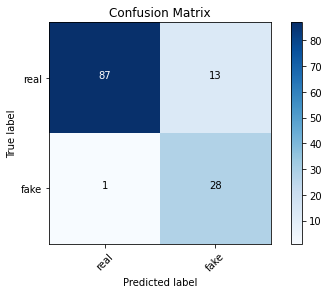

In [27]:
main_vgg16()

### Mobile Net

In [28]:
def model_training_mobile_net(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - using mobile net model layers as base layers for the new model.
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing mobile net ")
    mobile_net_model = keras.applications.mobilenet.MobileNet()
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in mobile_net_model.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=20)
    
    return model

In [29]:
def main_mobile_net():
  '''
  calling all functions
  '''
    
  # getting labels to each data set
  df_training = data_organization(train_path)
  df_validation = data_organization(valid_path)
  df_testing = data_organization(test_path)
    
  # getting train and validation data in numpy 
  train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'])
  val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'])
    
  # get the trained model
  model = model_training_mobile_net(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
    
  # get the results
  predictions, true_labels = get_predictions(model = model, df_testing=df_testing)
    
  #
  model_performance(predictions=predictions, true_labels=true_labels)


Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing mobile net 
17235968/17225924 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training network for 16 epochs...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
30/30 [==============================] - 6s 137ms/step - loss: 1.4305 - accuracy: 0.5167 - val_loss: 1.1300 - val_accuracy: 0.4500
Epoch 2/20
30/30 [==============================] - 3s 110ms/step - loss: 1.0535 - accuracy: 0.4900 - val_loss: 1.0302 - val_accuracy: 0.4900
Epoch 3/20
30/30 [==============================] - 5s 163ms/step - loss: 1.0088 - accuracy: 0.4800 - val_loss: 0.9608 - val_accuracy: 0.5300
Epoch 4/20
30/30 [==============================] - 3s 112ms/step - loss: 0.9446 - accuracy: 0.5367 - val_loss: 0.8912 - val_accuracy: 0.5800
Epoch 5/20
30/30 [==============================] - 3s 115ms/step - loss: 0.9022 - accuracy: 0.5400 - val_loss: 0.8251 - val_accuracy: 0.6200
Epoch 6/20
30/30 [==============================] - 3s 115ms/step - loss: 0.8711 - accuracy: 0.5700 - val_loss: 0.7777 - val_accuracy: 0.6500
Epoch 7/20
30/30 [==============================] - 3s 111ms/step - loss: 0.8641 - accuracy: 0.5967 - val_loss: 0.7269 - val_accuracy: 0.6600
Epoch 

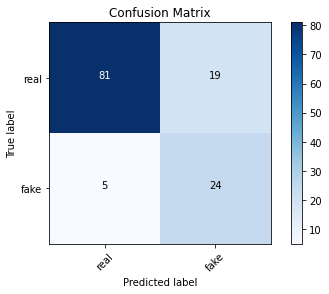

In [30]:
main_mobile_net()

# Multi Model Training



Models to be trained 


*   EfficientNetV2L
*   EfficientNetB7
*   NASNetLarge
*   InceptionResNetV2



In [41]:
eff_netv2l = keras.applications.efficientnet_v2.EfficientNetV2L()
eff_netb7 = keras.applications.efficientnet.EfficientNetB7()
nas_net_large = keras.applications.nasnet.NASNetLarge()
inc_resnetv2 = keras.applications.inception_resnet_v2.InceptionResNetV2()

225222656/225209952 [==============================] - 3s 0us/step


In [59]:
def model_training_multi_models(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing all models ")
    eff_netv2l = keras.applications.efficientnet_v2.EfficientNetV2L()
    eff_netb7 = keras.applications.efficientnet.EfficientNetB7()
    nas_net_large = keras.applications.nasnet.NASNetLarge()
    inc_resnetv2 = keras.applications.inception_resnet_v2.InceptionResNetV2()

    list_all_models = [eff_netv2l, eff_netb7, nas_net_large, inc_resnetv2]
    trained_models = {}

    for model_ in list_all_models:
      print("[INFO] Training model ", model_.name)
      # getting a sequential model and freezing the previous
      model = Sequential()
      for layer in model_.layers[:-1]:
          model.add(layer)
      
      # After poping the last layer, freeze the previous layers and adding a new dense output layer
      for layer in model.layers:
          layer.trainable = False
      model.add(Dense(2, activation='softmax'))
      
      # initialize the optimizer and model
      print("[INFO] compiling model...")
      opt = Adam(lr=INIT_LR)
      
      model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
      
      # train the network
      print("[INFO] training network for {} epochs...".format(EPOCHS))
      
      model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
          validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
          epochs=20)
      trained_models[model_.name] = model
      print(type(trained_models))
    
    return trained_models

In [57]:
def main_all_models():
  '''
  calling all functions
  '''
    
  # getting labels to each data set
  df_training = data_organization(train_path)
  df_validation = data_organization(valid_path)
  df_testing = data_organization(test_path)
    
  # getting train and validation data in numpy 
  train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'])
  val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'])
    
  # get the trained model
  all_models = model_training_multi_models(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
  print(type(all_models))
  print(all_models)
  all_predictions = {}
  # get the results
  # for model_name in all_models.keys():
  #   predictions, true_labels = get_predictions(model = all_models[model_name], df_testing=df_testing)
  #   all_predictions[model_name] = {'predictions': predictions, 'true_labels': true_labels}
  # return all_predictions



In [58]:
all_results = main_all_models()

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing all models 
[INFO] Training model  efficientnetv2-l


ValueError: ignored

In [60]:
eff_netv2l.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 480, 480, 3)  0           ['input_9[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 32  864         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

In [61]:
eff_netb7.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 600, 600, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling_3[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 601, 601, 3)  0           ['normalization[0][0

In [62]:
nas_net_large.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

In [63]:
inc_resnetv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               